## Section 1: Download Malaria dataset

In [1]:
# Do not modify this cell
# Download the Malaria dataset from Google Drive
# Or download it to your local machine if you need: https://drive.google.com/file/d/13iJlt5bJCc3dW1pm4UPns1AgOHyoWQ0a/view?usp=drive_link

import gdown
!gdown 13iJlt5bJCc3dW1pm4UPns1AgOHyoWQ0a
!unzip hw5_data.zip -d hw5_data

Streaming output truncated to the last 5000 lines.
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144714_cell_192.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144714_cell_195.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144714_cell_22.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144714_cell_24.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144714_cell_34.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144714_cell_90.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144855_cell_133.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144855_cell_143.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144855_cell_147.png  
 extracting: hw5_data/data/train/uninfected/C87P48ThinF_IMG_20150820_144855_cell_172.png  
 extracting: hw5_data/data/train/uninfected

In [2]:
# import your package
import os
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms.functional as F
import numpy as np
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix

torch.manual_seed(0)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)   # make sure you are using GPU (CUDA)

Device:  cuda


Dimensions of Parasitized Image: (127, 151)
Dimensions of Uninfected Image: (142, 136)


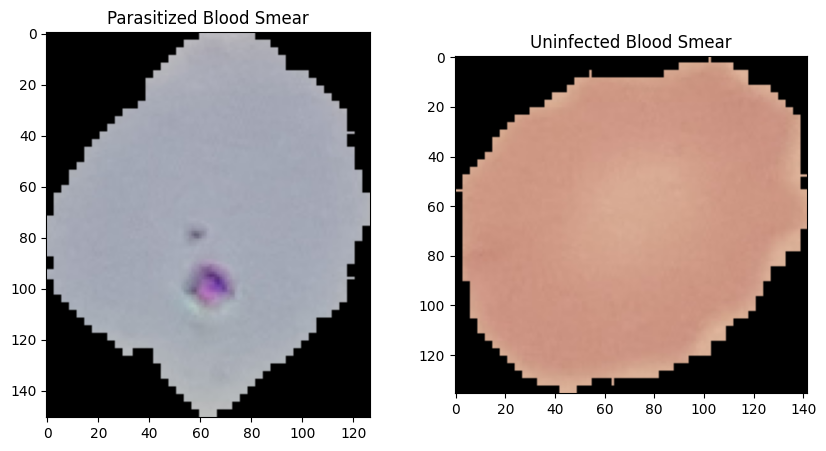

In [3]:
# image visualization
data_path = 'hw5_data/data/train'
file_list = os.listdir(data_path)

parasitized_image_path = os.path.join(data_path, 'parasitized', os.listdir(os.path.join(data_path, 'parasitized'))[0])
parasitized_image = Image.open(parasitized_image_path)

uninfected_image_path = os.path.join(data_path, 'uninfected', os.listdir(os.path.join(data_path, 'uninfected'))[0])
uninfected_image = Image.open(uninfected_image_path)

print("Dimensions of Parasitized Image:", parasitized_image.size)
print("Dimensions of Uninfected Image:", uninfected_image.size)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(parasitized_image)
plt.title('Parasitized Blood Smear')

plt.subplot(1, 2, 2)
plt.imshow(uninfected_image)
plt.title('Uninfected Blood Smear')

plt.show()

In [4]:
# store the parameters and hyperparameters in the config dictionary
config = {
    "batch_size": 64,
    "epoch": 10,
    "learning_rate": 0.001,
    "input_size": (224, 224),
    "num_classes": 2,  # parasitized or uninfected
    "device": DEVICE,
}


## Section 2: Prepare your dataset and dataloader

In [5]:
data_dir = "hw5_data/data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")

# TODO: implement your image transformations
# Please refer to: https://pytorch.org/vision/stable/transforms.html
# Most transformations can be done before converting the image into a tensor (using ToTensor())
# Some transforms (e.g. normalization) should be performed after ToTensor()
# Do you need data augmentation on the validation dataset?
# Note: for this dataset, images have different sizes (height and width). Make sure to crop/resize the all the images to the same size.
# Define mean and std for normalization
mean = [0.454, 0.426, 0.529]
std = [0.282, 0.269, 0.332]

# Augmentation and normalization transforms for training
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.RandomRotation(90),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

# Create datasets
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = torchvision.datasets.ImageFolder(val_dir, transform=valid_transforms)

# create data loaders using the dataset classes
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

Original Image


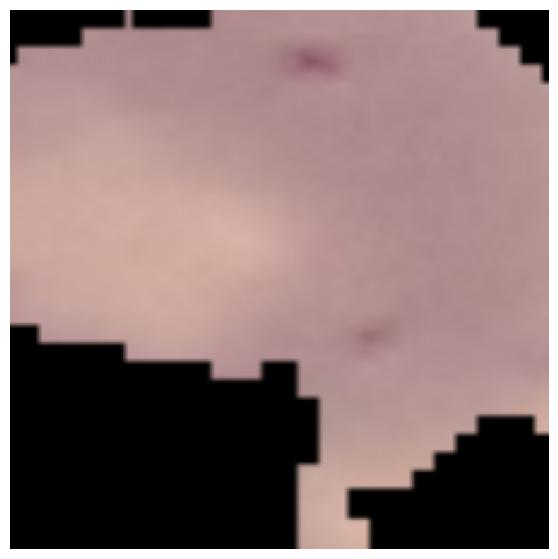

Transformed Image


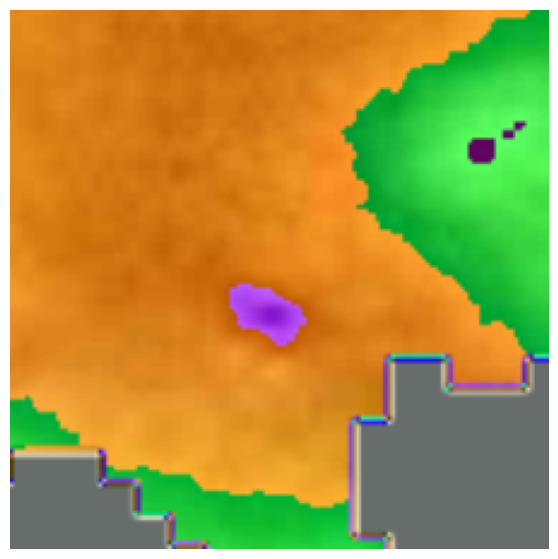

In [6]:
# Visualizing transformation
# Function to denormalize and display an image
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.454, 0.426, 0.529])
    std = np.array([0.282, 0.269, 0.332])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

data_iter = iter(train_loader)
images, _ = next(data_iter)

# Display original image
print("Original Image")
plt.figure(figsize=(7, 7))
imshow(images[0])
plt.show()

# Display transformed image
print("Transformed Image")
plt.figure(figsize=(7, 7))
transformed_img = train_transforms(F.to_pil_image(images[0]))
imshow(transformed_img)
plt.show()


In [7]:
print("Number of classes    : ", len(train_dataset.classes))
print("Shape of image       : ", train_dataset[0][0].shape)
print("Train batches        : ", train_loader.__len__())
print("No. of train images  : ", train_dataset.__len__())
print("No. of valid images  : ", valid_dataset.__len__())

Number of classes    :  2
Shape of image       :  torch.Size([3, 224, 224])
Train batches        :  275
No. of train images  :  17564
No. of valid images  :  4312


In [8]:
# Check if your dataloader is working
# The shape of images should be: (batch_size, number of channels, image height, image width)
# The shape of labels should be: (batch_size)
for _, data in enumerate(train_loader):
    images, labels = data
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 224, 224]) torch.Size([64])


## Section 3. Create your CNN model

In [9]:
class Model(nn.Module):
    def __init__(self, num_classes=2):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.fc(x)
        return x

model = Model(num_classes=2).to(DEVICE)


In [10]:
# We provide the loss function and optimizer here. Feel free to choose any other loss function and optimizer if you need.
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Section 4. Train your model

In [11]:
# train/validation/test functions for each epoch have been provided and you don't need to modify them.
# Reference: 11785 Introduction to Deep Learning
def train(model, dataloader, optimizer, criterion):
    model.train()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    num_correct = 0.0
    total_loss = 0.0

    # Iterate all the training data and pass them into the model
    for idx, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # zero all the gradients of the variable

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Forward propagation
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward propagation
        loss.backward()
        # Gradient descent
        optimizer.step()

        # Update no. of correct image predictions and loss so that we can calculate the accuracy and loss for this epoch easily
        num_correct += int((torch.argmax(outputs, dim=1)==labels).sum())
        total_loss += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc = "{:.04f}%".format(num_correct/(config["batch_size"]*(idx+1))*100),
            loss = "{:.04f}".format(float(total_loss/(idx+1))),
        )

        batch_bar.update()

    batch_bar.close()

    # Calculate the total accuracy and loss for this epoch
    acc = num_correct/(config["batch_size"]*len(dataloader))*100
    total_loss = float(total_loss/len(dataloader))

    return acc, total_loss

In [12]:
def validate(model, dataloader, criterion):
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Validate')

    num_correct = 0.0
    total_loss = 0.0

    for idx, (images, labels) in enumerate(dataloader):

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        # For validation, we use the inference mode
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, dim=1)==labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc= "{:.04f}%".format(num_correct/(config["batch_size"]*(idx+1))*100),
            loss= "{:.04f}".format(float(total_loss/(idx+1)))
        )

        batch_bar.update()

    batch_bar.close()
    acc = num_correct/(config["batch_size"]*len(dataloader))*100
    total_loss = float(total_loss/len(dataloader))

    return acc, total_loss

In [13]:
# create lists that track your loss and accuracy during training
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

# Iterate over the number of epochs specified in your config dictionary.
for epoch in range(config["epoch"]):
    # Train
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}".format(
        epoch + 1,
        config["epoch"],
        train_acc,
        train_loss
    ))

    # Validate
    val_acc, val_loss = validate(model, valid_loader, criterion)

    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    # Store loss and accuracy
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)



Epoch 1/10: 
Train Acc 55.8807%	 Train Loss 0.6886


Val Acc 65.8088%	 Val Loss 0.6794



Epoch 2/10: 
Train Acc 62.1136%	 Train Loss 0.6668


Val Acc 63.7408%	 Val Loss 0.6578



Epoch 3/10: 
Train Acc 64.5511%	 Train Loss 0.6324


Val Acc 65.8548%	 Val Loss 0.6756



Epoch 4/10: 
Train Acc 66.9545%	 Train Loss 0.6149


Val Acc 71.6682%	 Val Loss 0.7017



Epoch 5/10: 
Train Acc 68.8125%	 Train Loss 0.6053


Val Acc 69.8529%	 Val Loss 0.7291



Epoch 6/10: 
Train Acc 70.8466%	 Train Loss 0.5947


Val Acc 76.3557%	 Val Loss 0.7269



Epoch 7/10: 
Train Acc 73.5398%	 Train Loss 0.5787


Val Acc 77.9871%	 Val Loss 0.6996



Epoch 8/10: 
Train Acc 75.9602%	 Train Loss 0.5568


Val Acc 81.7555%	 Val Loss 0.6721



Epoch 9/10: 
Train Acc 77.8580%	 Train Loss 0.5308


Val Acc 83.2950%	 Val Loss 0.6273



Epoch 10/10: 
Train Acc 78.8182%	 Train Loss 0.5126


Val Acc 83.8465%	 Val Loss 0.5564


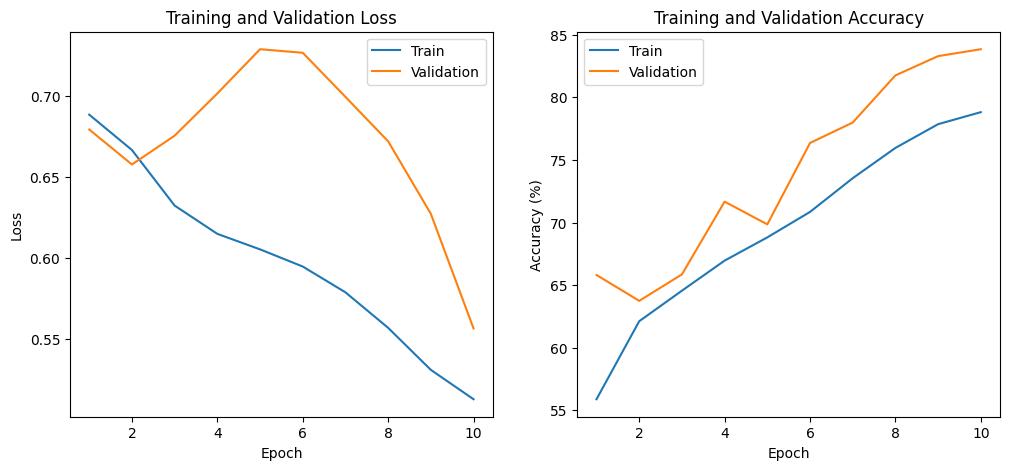

In [14]:
# Plot your loss and accuracy
epochs = range(1, config["epoch"] + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Train')
plt.plot(epochs, val_loss_list, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label='Train')
plt.plot(epochs, val_acc_list, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Section 5. Evaluate your model

In [15]:
# create the dataset and dataloader for your test data
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean, std=std)
])

test_dir = os.path.join(data_dir, "test")

test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=test_transforms)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [16]:
# No need to modify
def test(model, dataloader):

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  pred_labels = []
  true_labels = []

  for _, (images, labels) in enumerate(dataloader):
      images = images.to(DEVICE)

      with torch.inference_mode():
          # Predict on the test data
          outputs = model(images)

      outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy().tolist()
      labels = labels.detach().cpu().numpy().tolist()
      pred_labels.extend(outputs)
      true_labels.extend(labels)

      batch_bar.update()

  batch_bar.close()

  return pred_labels, true_labels

In [17]:
# Import necessary libraries

# Make predictions on the test set
model.eval()  # Set the model to evaluation mode
test_predictions, true_labels = test(model, test_loader)

# Calculate the accuracy score
accuracy = accuracy_score(true_labels, test_predictions)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, test_predictions)
print('Confusion Matrix:')
print(conf_matrix)

Test Accuracy: 88.56%
Confusion Matrix:
[[3002  569]
 [ 248 3324]]


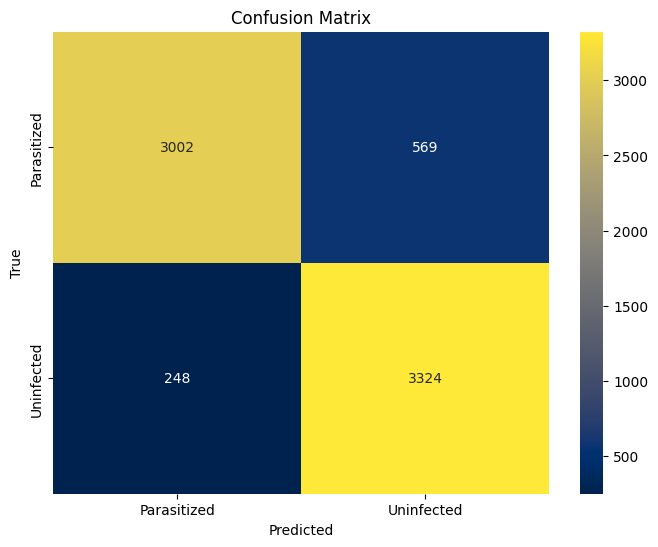

In [18]:
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="cividis", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

class_names = ['Parasitized', 'Uninfected']

plot_confusion_matrix(conf_matrix, class_names)